<a href="https://colab.research.google.com/github/ggruszczynski/gpu_colab/blob/main/90_taichi_wave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install taichi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.2 MB/s eta 0:00:00


# Wave equation

In this tutorial we will solve the wave equation on GPU using taichi framework.

In [2]:
import matplotlib.pyplot as plt
import taichi as ti

[Taichi] version 1.7.0, llvm 15.0.4, commit 2fd24490, linux, python 3.10.12


[Taichi] Starting on arch=cuda
waves


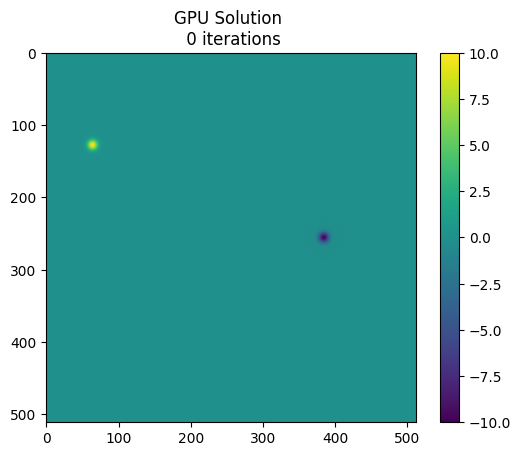

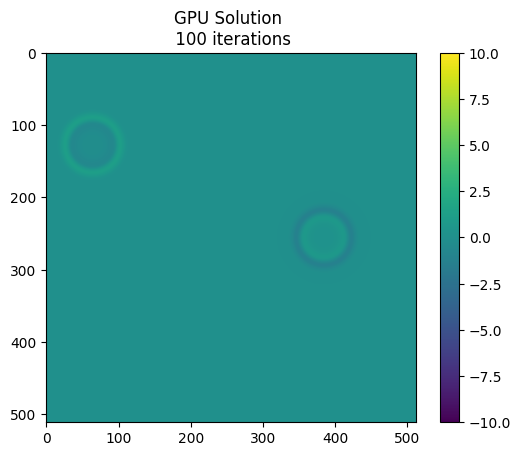

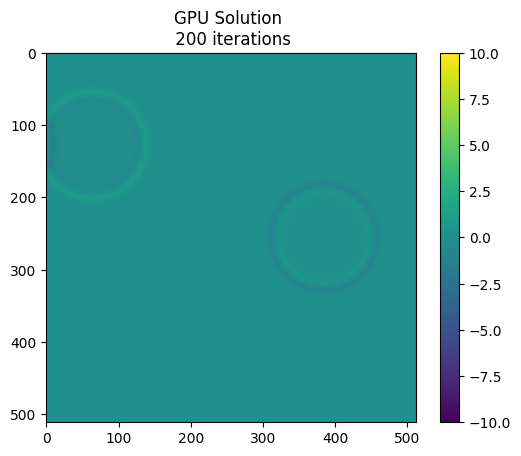

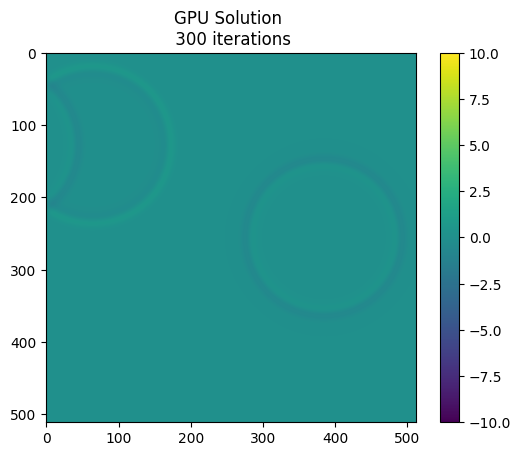

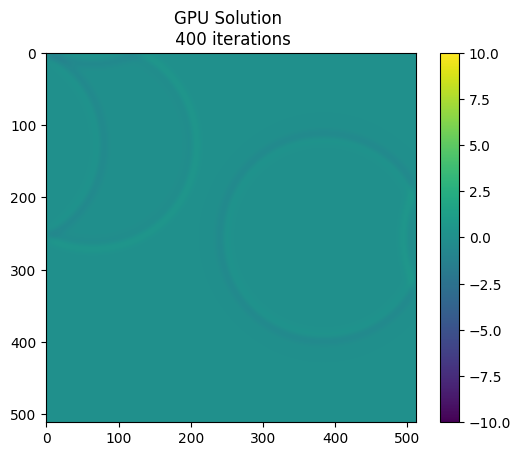

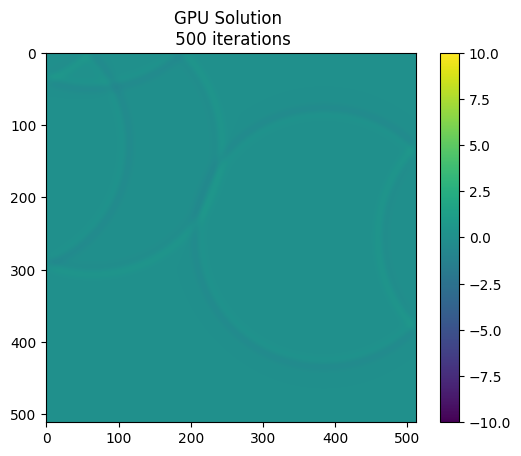

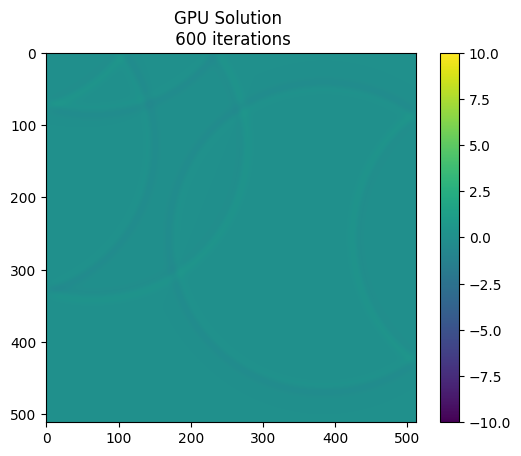

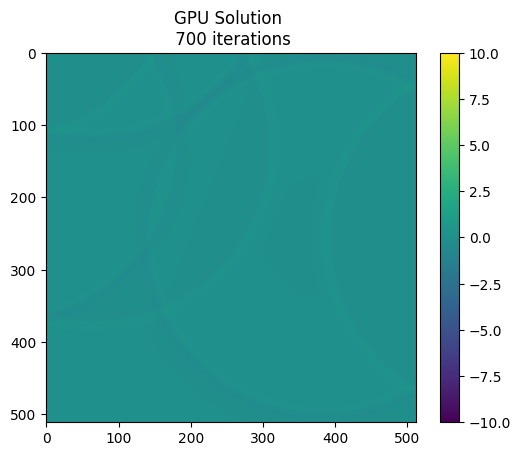

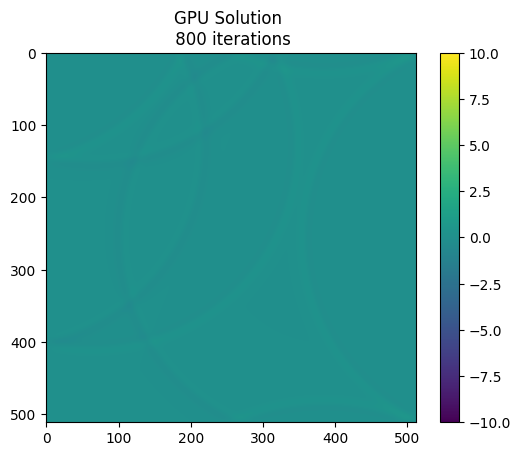

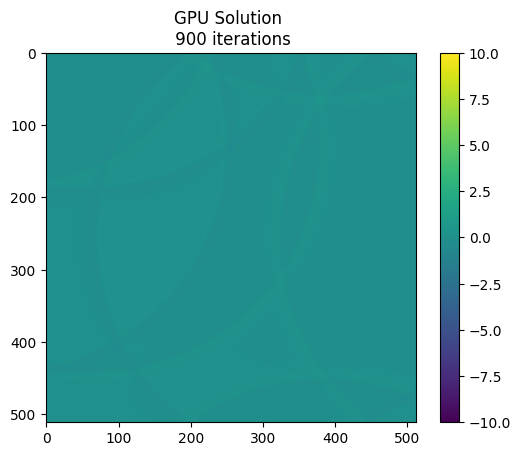

In [10]:
# Wave equation

# Insipiration
# https://github.com/taichi-dev/taichi/blob/master/python/taichi/examples/simulation/waterwave.py
# https://docs.tclb.io/tutorials/model-development/1.-finite-difference-wave-equation/


ti.init(arch=ti.gpu)

gravity = 2.0  # larger gravity makes wave propagates faster
damping = 0.2  # larger damping makes wave vanishes faster when propagating
dx = 0.02
dt = 0.01
shape = 512, 512

height = ti.field(dtype=float, shape=shape)
velocity = ti.field(dtype=float, shape=shape)
height.fill(0)
velocity.fill(0)

@ti.kernel
def create_wave(amplitude: ti.f32, x: ti.f32, y: ti.f32):
    for i, j in ti.ndrange((1, shape[0] - 1), (1, shape[1] - 1)):
        r2 = (i - x) ** 2 + (j - y) ** 2
        height[i, j] = height[i, j] + amplitude * ti.exp(-0.02 * r2)


@ti.func
def laplacian_h(i, j):
    return (-4 * height[i, j] + height[i, j - 1] + height[i, j + 1] + height[i + 1, j] + height[i - 1, j]) / (4 * dx**2)


@ti.kernel
def update():
    for i, j in ti.ndrange((1, shape[0] - 1), (1, shape[1] - 1)):
        velocity[i, j] = velocity[i, j] + (gravity * laplacian_h(i, j) - damping * velocity[i, j]) * dt

    for i, j in ti.ndrange((1, shape[0] - 1), (1, shape[1] - 1)):
        height[i, j] = height[i, j] + velocity[i, j] * dt



def main():
    print("waves")

    create_wave(10, int(0.25*shape[0]), int(0.125*shape[0]) )
    create_wave(-10, int(0.5*shape[0]), int(0.75*shape[0]) )

    for i in range(1000):
      update()
      if i % 100 == 0:
        plt.imshow(height.to_numpy(), vmin = -10, vmax =10, cmap='viridis')
        plt.colorbar()
        plt.title(f'GPU Solution \n {i} iterations')
        plt.show()

if __name__ == "__main__":
    main()